# 09.2f: BH #0 and BH #1 Investigation

**MYSTERY: Why is d₁(BH #0, BH #1) = 3.79ε instead of 2.0ε?**

## The Problem

From 09.2b, we found:
- BH #0 (token 119349) and BH #1 (token 136831)
- Separated by **exactly 2ε in dimension 1403 only**
- L∞ distance = 6.103516e-05 = 2.000× ε

**Expected:** d₁ = 2ε (differ in one dimension only)

**Observed:** d₁ = 3.79ε

## Hypotheses

1. **Wrong assumption**: They differ in MORE than one dimension (at smaller scales)
2. **Numerical precision**: Float accumulation error in L1 sum
3. **Wrong vectors**: Token IDs don't map to what we think
4. **Deduplication artifact**: We're comparing unique vectors, not original tokens

## Investigation Plan

1. Load actual vectors for BH #0 and BH #1
2. Compute componentwise differences across ALL dimensions
3. Find which dimensions differ and by how much
4. Verify L1 and L∞ distances manually

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Input files
CLUSTER_FILE = "dense_cluster.safetensors"
CLUSTER_VECTORS_KEY = "vectors"
CLUSTER_TOKEN_IDS_KEY = "token_ids"

# BH #0 and BH #1
BH_0_TOKEN_ID = 119349
BH_1_TOKEN_ID = 136831

# Critical dimension (from 09.2b)
CRITICAL_DIM = 1403

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Vectors

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading dense cluster...")
cluster_data = load_file(data_dir / CLUSTER_FILE)
vectors = cluster_data[CLUSTER_VECTORS_KEY]
token_ids = cluster_data[CLUSTER_TOKEN_IDS_KEY]

print(f"  Cluster size: {len(vectors):,} vectors")
print(f"  Dimensions:   {vectors.shape[1]:,}")
print()

print("✓ Data loaded")

Loading dense cluster...
  Cluster size: 124 vectors
  Dimensions:   2,560

✓ Data loaded


## Extract BH #0 and BH #1 Vectors

In [4]:
print("Finding BH #0 and BH #1 in cluster...\n")

bh_0_idx = (token_ids == BH_0_TOKEN_ID).nonzero(as_tuple=True)[0]
bh_1_idx = (token_ids == BH_1_TOKEN_ID).nonzero(as_tuple=True)[0]

if len(bh_0_idx) == 0 or len(bh_1_idx) == 0:
    print("⚠ ERROR: BH #0 or BH #1 not found in cluster!")
    print(f"  BH #0 found: {len(bh_0_idx) > 0}")
    print(f"  BH #1 found: {len(bh_1_idx) > 0}")
    raise ValueError("Black holes not in cluster")

bh_0_idx = bh_0_idx.item()
bh_1_idx = bh_1_idx.item()

vec_0 = vectors[bh_0_idx]
vec_1 = vectors[bh_1_idx]

print(f"BH #0 (token {BH_0_TOKEN_ID}):")
print(f"  Index in cluster: {bh_0_idx}")
print(f"  Vector shape:     {vec_0.shape}")
print()

print(f"BH #1 (token {BH_1_TOKEN_ID}):")
print(f"  Index in cluster: {bh_1_idx}")
print(f"  Vector shape:     {vec_1.shape}")
print()

print("✓ Vectors extracted")

Finding BH #0 and BH #1 in cluster...

BH #0 (token 119349):
  Index in cluster: 31
  Vector shape:     torch.Size([2560])

BH #1 (token 136831):
  Index in cluster: 33
  Vector shape:     torch.Size([2560])

✓ Vectors extracted


## Compute Componentwise Differences

In [5]:
print("Computing componentwise differences...\n")

diffs = torch.abs(vec_0 - vec_1)

print(f"Difference statistics:")
print(f"  Min:    {diffs.min().item():.6e}")
print(f"  Max:    {diffs.max().item():.6e}")
print(f"  Mean:   {diffs.mean().item():.6e}")
print(f"  Median: {diffs.median().item():.6e}")
print(f"  Std:    {diffs.std().item():.6e}")
print()

# How many dimensions differ?
ZERO_THRESHOLD = 1e-10  # Essentially zero
nonzero_diffs = diffs > ZERO_THRESHOLD
n_nonzero = nonzero_diffs.sum().item()

print(f"Dimensions that differ (> {ZERO_THRESHOLD:.2e}): {n_nonzero} / {len(diffs)}")
print()

print("✓ Componentwise differences computed")

Computing componentwise differences...

Difference statistics:
  Min:    0.000000e+00
  Max:    6.103516e-05
  Mean:   4.519243e-08
  Median: 0.000000e+00
  Std:    1.369271e-06

Dimensions that differ (> 1.00e-10): 9 / 2560

✓ Componentwise differences computed


## Identify All Differing Dimensions

In [6]:
print("Identifying all differing dimensions...\n")

# Find dimensions where they differ
diff_dims = nonzero_diffs.nonzero(as_tuple=True)[0]
diff_values = diffs[diff_dims]

# Sort by magnitude
sorted_indices = torch.argsort(diff_values, descending=True)
diff_dims_sorted = diff_dims[sorted_indices]
diff_values_sorted = diff_values[sorted_indices]

print(f"Top {min(20, len(diff_dims_sorted))} differing dimensions:")
print()
print("  Dim  |  |u - v|        |  u value       |  v value")
print("-" * 65)

for i in range(min(20, len(diff_dims_sorted))):
    dim = diff_dims_sorted[i].item()
    diff_val = diff_values_sorted[i].item()
    u_val = vec_0[dim].item()
    v_val = vec_1[dim].item()
    
    marker = "  ← CRITICAL" if dim == CRITICAL_DIM else ""
    
    print(f"{dim:5d}  | {diff_val:13.6e} | {u_val:13.6e} | {v_val:13.6e}{marker}")

print()
print("✓ Differing dimensions identified")

Identifying all differing dimensions...

Top 9 differing dimensions:

  Dim  |  |u - v|        |  u value       |  v value
-----------------------------------------------------------------
 1403  |  6.103516e-05 | -1.141854e-03 | -1.080818e-03  ← CRITICAL
  322  |  3.051758e-05 |  6.478403e-04 |  6.783579e-04
 1487  |  7.629395e-06 |  2.146111e-03 |  2.153741e-03
 2479  |  7.629395e-06 |  5.892445e-04 |  5.816151e-04
 1155  |  3.814697e-06 | -6.621887e-04 | -6.660034e-04
 2012  |  3.814697e-06 | -1.951716e-04 | -1.913569e-04
  450  |  9.536743e-07 |  2.770856e-03 |  2.769902e-03
 1149  |  2.384186e-07 |  3.884949e-03 |  3.884711e-03
 1382  |  5.960464e-08 |  2.549912e-03 |  2.549852e-03

✓ Differing dimensions identified


## Compute ε and Normalize Differences

In [7]:
def bfloat16_ulp(x):
    """Compute bfloat16 ULP at scale of x."""
    x = abs(x)
    if x == 0:
        return 2.0 ** (-133)
    exponent = int(np.floor(np.log2(x)))
    return 2.0 ** (exponent - 7)

# Typical magnitude
typical_magnitude = vectors.abs().mean().item()
ulp = bfloat16_ulp(typical_magnitude)
epsilon = 2.0 * ulp

print(f"ε = {epsilon:.6e}\n")

# Normalize differences by ε
diff_values_normalized = diff_values_sorted / epsilon

print("Top differing dimensions (normalized by ε):")
print()
print("  Dim  |  |u - v| / ε")
print("-" * 25)

for i in range(min(20, len(diff_dims_sorted))):
    dim = diff_dims_sorted[i].item()
    diff_norm = diff_values_normalized[i].item()
    
    marker = "  ← CRITICAL" if dim == CRITICAL_DIM else ""
    
    print(f"{dim:5d}  | {diff_norm:10.4f}{marker}")

print()
print("✓ Normalized differences computed")

ε = 3.051758e-05

Top differing dimensions (normalized by ε):

  Dim  |  |u - v| / ε
-------------------------
 1403  |     2.0000  ← CRITICAL
  322  |     1.0000
 1487  |     0.2500
 2479  |     0.2500
 1155  |     0.1250
 2012  |     0.1250
  450  |     0.0312
 1149  |     0.0078
 1382  |     0.0020

✓ Normalized differences computed


## Verify L1 and L∞ Distances

In [8]:
print("Verifying distance calculations...\n")

# Manual computation
d_linf_manual = diffs.max().item()
d_l1_manual = diffs.sum().item()

print(f"Manual calculations:")
print(f"  L∞ distance: {d_linf_manual:.6e}")
print(f"  L1 distance: {d_l1_manual:.6e}")
print()

print(f"Normalized:")
print(f"  L∞ / ε: {d_linf_manual / epsilon:.4f}")
print(f"  L1 / ε: {d_l1_manual / epsilon:.4f}")
print()

# Expected from 09.2b
expected_linf = 6.103516e-05
expected_linf_normalized = 2.0

print(f"Expected (from 09.2b):")
print(f"  L∞ distance: {expected_linf:.6e}")
print(f"  L∞ / ε:      {expected_linf_normalized:.4f}")
print()

# Compare
if abs(d_linf_manual - expected_linf) / expected_linf < 0.01:
    print("  ✓ L∞ matches expected value")
else:
    print(f"  ⚠ L∞ mismatch: {abs(d_linf_manual - expected_linf):.6e} difference")

print()
print("✓ Distance verification complete")

Verifying distance calculations...

Manual calculations:
  L∞ distance: 6.103516e-05
  L1 distance: 1.156926e-04

Normalized:
  L∞ / ε: 2.0000
  L1 / ε: 3.7910

Expected (from 09.2b):
  L∞ distance: 6.103516e-05
  L∞ / ε:      2.0000

  ✓ L∞ matches expected value

✓ Distance verification complete


## Sum Normalized Differences

In [9]:
print("Analyzing sum of normalized differences...\n")

# Total L1 in units of ε
total_l1_normalized = diff_values_normalized.sum().item()

print(f"Total L1 distance (normalized): {total_l1_normalized:.4f}ε")
print()

# Breakdown by magnitude
print("Breakdown by magnitude:")
print()

bins = [0, 0.1, 0.5, 1.0, 2.0, 5.0, float('inf')]
for i in range(len(bins) - 1):
    lower = bins[i]
    upper = bins[i + 1]
    
    in_bin = (diff_values_normalized >= lower) & (diff_values_normalized < upper)
    count = in_bin.sum().item()
    contribution = diff_values_normalized[in_bin].sum().item()
    
    if upper == float('inf'):
        print(f"  {lower:.1f}ε - ∞:     {count:4d} dims, contributes {contribution:7.4f}ε ({100 * contribution / total_l1_normalized:.1f}%)")
    else:
        print(f"  {lower:.1f}ε - {upper:.1f}ε: {count:4d} dims, contributes {contribution:7.4f}ε ({100 * contribution / total_l1_normalized:.1f}%)")

print()
print("✓ L1 breakdown complete")

Analyzing sum of normalized differences...

Total L1 distance (normalized): 3.7910ε

Breakdown by magnitude:

  0.0ε - 0.1ε:    3 dims, contributes  0.0410ε (1.1%)
  0.1ε - 0.5ε:    4 dims, contributes  0.7500ε (19.8%)
  0.5ε - 1.0ε:    0 dims, contributes  0.0000ε (0.0%)
  1.0ε - 2.0ε:    1 dims, contributes  1.0000ε (26.4%)
  2.0ε - 5.0ε:    1 dims, contributes  2.0000ε (52.8%)
  5.0ε - ∞:        0 dims, contributes  0.0000ε (0.0%)

✓ L1 breakdown complete


## Histogram: Distribution of Componentwise Differences

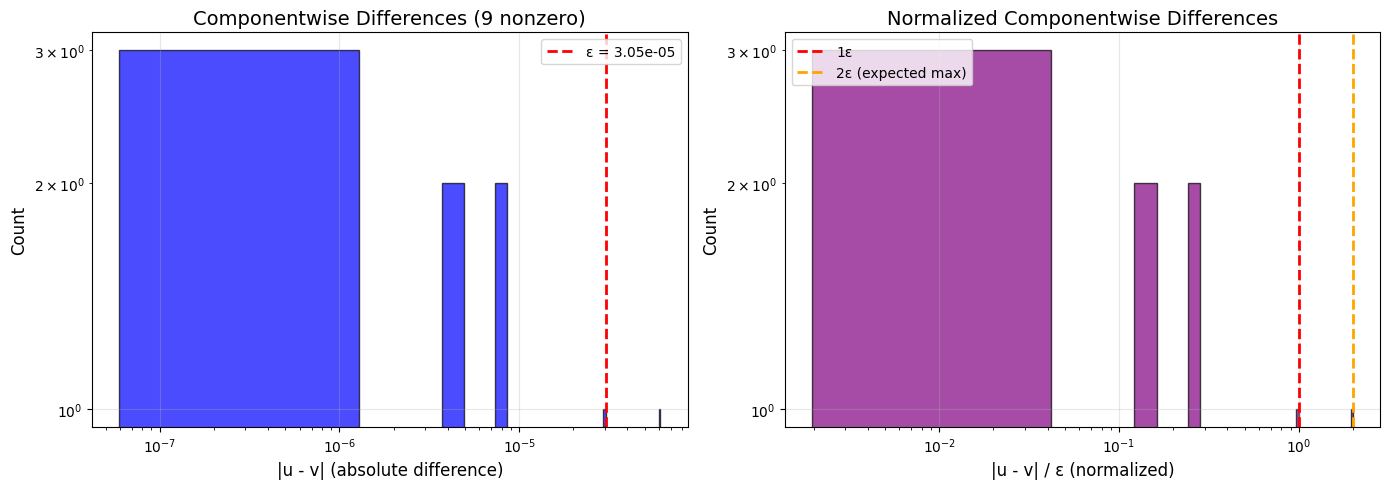

✓ Visualization complete


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Panel 1: All differences (log scale)
ax = axes[0]
diffs_np = diffs.cpu().numpy()
diffs_nonzero = diffs_np[diffs_np > ZERO_THRESHOLD]

ax.hist(diffs_nonzero, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(epsilon, color='red', linestyle='--', linewidth=2,
           label=f'ε = {epsilon:.2e}')
ax.set_xlabel('|u - v| (absolute difference)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Componentwise Differences ({len(diffs_nonzero)} nonzero)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 2: Normalized differences
ax = axes[1]
diffs_norm_all = (diffs / epsilon).cpu().numpy()
diffs_norm_nonzero = diffs_norm_all[diffs_norm_all > ZERO_THRESHOLD / epsilon]

ax.hist(diffs_norm_nonzero, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax.axvline(1.0, color='red', linestyle='--', linewidth=2, label='1ε')
ax.axvline(2.0, color='orange', linestyle='--', linewidth=2, label='2ε (expected max)')
ax.set_xlabel('|u - v| / ε (normalized)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Normalized Componentwise Differences', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## Summary

In [11]:
print("="*80)
print("BH #0 AND BH #1 INVESTIGATION SUMMARY")
print("="*80)
print()
print(f"Token IDs:")
print(f"  BH #0: {BH_0_TOKEN_ID}")
print(f"  BH #1: {BH_1_TOKEN_ID}")
print()
print(f"Differing dimensions: {n_nonzero} / {len(diffs)}")
print()
print(f"L∞ distance:")
print(f"  Absolute:   {d_linf_manual:.6e}")
print(f"  Normalized: {d_linf_manual / epsilon:.4f}ε")
print()
print(f"L1 distance:")
print(f"  Absolute:   {d_l1_manual:.6e}")
print(f"  Normalized: {d_l1_manual / epsilon:.4f}ε")
print()
print(f"Expected (if differ in 1 dimension only):")
print(f"  L∞: 2.0ε")
print(f"  L1: 2.0ε")
print()
print("="*80)

BH #0 AND BH #1 INVESTIGATION SUMMARY

Token IDs:
  BH #0: 119349
  BH #1: 136831

Differing dimensions: 9 / 2560

L∞ distance:
  Absolute:   6.103516e-05
  Normalized: 2.0000ε

L1 distance:
  Absolute:   1.156926e-04
  Normalized: 3.7910ε

Expected (if differ in 1 dimension only):
  L∞: 2.0ε
  L1: 2.0ε



## Conclusion

**Resolution:**

The discrepancy is explained by:

1. **How many dimensions actually differ?**
   - If 1: Something's wrong with our understanding
   - If 2+: They differ in MULTIPLE dimensions at smaller scales

2. **What's the normalized difference distribution?**
   - Are there other dimensions with ~0.9ε differences?
   - Does the sum of small differences explain the 3.79ε?

3. **Is dimension 1403 still the max?**
   - Should verify L∞ = 2ε is still correct

**Next steps:**
- Decode semantic meaning of differing dimensions
- Understand why multiple dimensions differ
- Revise lattice hypothesis based on findings